# Time Series Prediction


In [3]:
# @ Lukman copyright 
# MIT Licence

In [389]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 

# imports below are for plotly 
import ipywidgets as widgets
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)   # for offline mode use
import plotly.figure_factory as ff
import plotly.offline as offline


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random


import yaml
import os
from utility import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
# check GPU availability for tensorflow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


# Data Preprocessing 

In [2]:
################################################################################
# load config file
try:
    with open("../config.yml", 'r') as ymlfile:
            cfg = yaml.safe_load(ymlfile)
except (IOError):
    print('config file is required. Put config file in current directory')
################################################################################

In [3]:
# # current working directory
# cwd = os.getcwd()
# # set the base directory. base directo
# BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# # cleaned data dir
# cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV1']['cleanedDir'] 
# # clean data Name
# cleandataName = cfg['cleanedconfig']['cleanedDataV1']['cleanedName']
# # traina and validation data name
# trainName= cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanTrain']
# validateName  = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanValidate']
# validation_split = cfg['cleanedconfig']['cleanedDataV1']['validationSplit']

In [7]:
# current working directory
cwd = os.getcwd()
# set the base directory. base directo
BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# cleaned data dir
cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV2']['cleanedDir'] 
# clean data Name
cleandataName = cfg['cleanedconfig']['cleanedDataV2']['cleanedName']
# traina and validation data name
trainName= cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanTrain']
validateName  = cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanValidate']
validation_split = cfg['cleanedconfig']['cleanedDataV2']['validationSplit']

In [8]:
# I will Load only the zero meter data set 
# same syntax applied for other data set
#meterOneDataLOaded= pd.read_csv(cleanedpath +  cleandataName ) # uncomment this if meter 1
meterOneDataLOaded= pd.read_feather(cleanedpath +  cleandataName ) # comment this if meter 0

# all meter types data set could be analysed in same manner

In [9]:
# set time stamp as index 
meterOneDataLOaded.set_index('timestamp',inplace=True);


In [10]:
y_train = meterOneDataLOaded['meter_reading']
X_train = meterOneDataLOaded.drop('meter_reading', axis=1)

In [11]:
#meterOneDataLOaded['dew_temperature'][1:2]

#### Training-Validation Spearation


In [12]:
#img_size=10;
VALIDATION_SIZE = 3000

validation_set = X_train[:VALIDATION_SIZE].values
validation_target = y_train[:VALIDATION_SIZE].values

train_set = X_train[VALIDATION_SIZE:].values
train_target = y_train[VALIDATION_SIZE:].values

print('validation-set',validation_set.shape, '|' ,'Train-set', train_set.shape)
print('------------------------------------------------')
print('validation-target',validation_target.shape,'|','Train-Target' ,train_target.shape)


validation-set (3000, 38) | Train-set (11527741, 38)
------------------------------------------------
validation-target (3000,) | Train-Target (11527741,)


In [14]:
#validation_set = Standardize(validation_set)
#validation_target = Standardize(validation_target)
#train_set = Standardize(train_set)
#train_target =  Standardize(train_target)



In [15]:
#validation_set.astype(np.float64, copy=False);

In [16]:
#train_set.astype(np.float64, copy=False);

In [17]:
#del X_train, y_train, meterOneDataLOaded

In [18]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_set.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_set
    global train_target
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_set = train_set[perm]
        train_target = train_target[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_set[start:end], train_target[start:end]

In [19]:
import random
def valdation_random_sampler(validation_set, validation_target, n_validation_sample):    
    rng = np.random.RandomState(42)  # reproducible results with a fixed seed
    indices = random.sample(range(0, len(validation_set)-1), n_validation_sample)
    #indices = np.arange(n_samples)
    
    rng.shuffle(indices)
    #print(indices)
    x_shuffled = validation_set[indices]
    y_shuffled = validation_target[indices]
    return x_shuffled,y_shuffled

In [20]:
#a,b= valdation_random_sampler(validation_set, validation_target,10)

### Modelling with LSTM

In [96]:
#Input Params
with tf.name_scope("input_target_placeholders"):    
    input_dim = 1
    ##The Input Layer as a Placeholder
    #Since we will provide data sequentially, the 'batch size'
    #is 1.
    input_layer = tf.placeholder(tf.float32, [1, input_dim*train_set.shape[1]],name="input_data")
    correct_output = tf.placeholder(tf.float32, [input_dim],name="target_data")

In [100]:
with tf.variable_scope("lstmLayer",reuse=tf.AUTO_REUSE ):    
    lstm_layer1 = rnn_cell.BasicLSTMCell(input_dim*2042,state_is_tuple=False)
    #lstm_layer1 = rnn_cell.BasicLSTMCell(input_dim*1,state_is_tuple=True)

    #The LSTM state as a Variable initialized to zeroes
    lstm_state1 = tf.Variable(tf.zeros([1, lstm_layer1.state_size]),trainable=False,name="initial_state")
    #lstm_state1 = tf.Variable(lstm_layer1.zero_state(1,lstm_layer1.state_size[-1] ), trainable=False)
    #Connect the input layer and initial LSTM state to the LSTM cell
    lstm_output1, lstm_state_output1 = lstm_layer1(input_layer, lstm_state1)
    #The LSTM state will get updated
    outputs = lstm_state1.assign(lstm_state_output1)

In [101]:
lstm_output1

<tf.Tensor 'lstmLayer_4/basic_lstm_cell/Mul_2:0' shape=(1, 2042) dtype=float32>

In [102]:
lstm_output1.shape

TensorShape([Dimension(1), Dimension(2042)])

In [462]:
with tf.name_scope("weight_Bias_learning_rate"):
    global_step = tf.Variable(0, trainable=False,name="global_step")
    starter_learning_rate = 1e-6
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.8, staircase=False,name ="Exponential_decay")
    ##The Regression-Output Layer
    #The Weights and Biases matrices first
    output_W1 = tf.Variable(tf.truncated_normal([int(lstm_output1.shape[1]), 1]),name="weight")
    output_b1 = tf.Variable(tf.truncated_normal([input_dim]),name="bias")


In [463]:
with tf.name_scope("prediction"):
    #Compute the output
    final_output = tf.matmul(lstm_output1, output_W1) + output_b1

In [464]:
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

#loss = my_normal_loss + reg_constant * sum(reg_losses)

In [465]:

#lambda_l2_reg=1e-9
#l2 = lambda_l2_reg * sum( tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "bias" in tf_var.name) )

In [473]:
bias_factor = 0.5
with tf.name_scope("RMS_error"):
    ##Calculate the Sum-of-Squares Error
    error = tf.sqrt(tf.reduce_mean(tf.squared_difference( tf.log(tf.abs(final_output)+1), tf.log(correct_output+1))))
    error2 = tf.reduce_mean(tf.squared_difference( tf.log(tf.abs(final_output)+1), tf.log(correct_output+1)))
    # tf.pow(tf.subtract(tf.log(tf.abs(final_output)+1), tf.log(correct_output+1), 2)
    error2 = error2 +(tf.constant(bias_factor)*tf.reduce_sum (reg_losses))

In [474]:
with tf.variable_scope("optimizer",reuse=tf.AUTO_REUSE ):    
    ##The Optimizer
    #Adam works best ProximalAdagradOptimizer
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(error2)

In [475]:
# Create a summary to monitor MSE
mse=tf.summary.tensor_summary("errors_Summary",error)
# Create a summary to monitor  predictions
prediction=tf.summary.tensor_summary("predictions_Summmary", final_output)
# Create a summary to monitor bias
bias_vec=tf.summary.tensor_summary("bias", output_b1)
# create sumary
#rate_vec=tf.summary.scalar("rate", learning_rate)


#histogram plot

error_stats=tf.summary.histogram("errors_Histogram",error)
weight_stats=tf.summary.histogram("weights_Histogram",output_W1)
bias_stats=tf.summary.histogram("biases_Histogram",output_b1)
#learning_stats=tf.histogram_summary("biases_Histogram",learning_rate)


#merged_summary_op =  tf.merge_all_summaries()
merged_summary_op =   tf.summary.merge([mse,prediction,bias_vec,error_stats,weight_stats,bias_stats])

In [476]:
##Session
sess = tf.Session()
#Initialize all Variables
sess.run(tf.global_variables_initializer())

In [477]:
# check path
checkpoint_path = cfg['savedModel']['myname']['Dir5'] 


In [446]:
checkpoint_path

'savedModels/lstmModel/'

In [447]:
# make path if not available
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [448]:
# save dir
save_dir =   checkpoint_path + cfg['savedModel']['myname']['modelName5']
# save dir 
saver = tf.train.Saver()

In [449]:
# logs_path = './lstm/'
#saver.restore(sess= sess, save_path= save_dir)


# Training

In [478]:

#tf.summary.FileWriter
train_errors = []
train_prediction = []
validation_errors = []
validation_prediction= []
display_step = 1
VALIDATON= True

n_validation_sample = 25
#writer = tf.summary.FileWriter(logs_path, graph= tf.get_default_graph())


# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 30
    
DROPOUT = 0.5
#BATCH_SIZES = 200

# set to 0 to train on all available data

BATCH_SIZE= 50

In [479]:
# data = np.array([
#     [1000, 10, 0.5],
#     [765, 5, 0.35],
#     [800, 7, 0.09], ])
# data = normalize(data, axis=0, norm='l1')
# data

In [ ]:
#update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# reset global parameters before traning/running
epochs_completed = 0
index_in_epoch = 0
num_examples = train_set.shape[0]

#*************************************************
# set to true in other to load saved model
restore = False 
if restore :
    saver.restore(sess= sess, save_path= save_dir)
#*************************************************

# run training
for i in range(TRAINING_ITERATIONS):

        #get new batch
        batch_xs, batch_ys = next_batch(BATCH_SIZE)  
        batch_xs = normalize(batch_xs,axis=0, norm='l2')
        temp = [] # store output temporally
        for m,n in zip(batch_xs,batch_ys):
            # check progress on every 1st,2nd,...,10th,20th,...,100th... step
            
            _, _, network_output,errors,summary = sess.run([outputs,
                                         train_step,
                                         final_output,error,merged_summary_op],
                                        feed_dict = {
                                            input_layer: m.reshape(1,train_set.shape[1]),
                                            correct_output: np.array([n])})
            
        
            #writer.add_summary(summary)
            #print(errors,network_output, n)
            temp.append(errors)
            train_prediction.append(network_output) # store predicted value
            
        saver.save(sess, save_dir)
        error_mean = np.mean(temp) 
        #print(error_mean)
        train_errors.append(error_mean)
               
        if(VALIDATON):
            val_train, val_tar = valdation_random_sampler(validation_set, validation_target, n_validation_sample)
            temp_ = []
            val_train=  normalize(val_train,axis=0, norm='l1')
            for k,l in zip(val_train,val_tar):
                sess.run(lstm_state1.assign(tf.zeros([1, lstm_layer1.state_size])))

                final_outputs, val_error = sess.run([
                                          final_output, error],
                                         feed_dict = {
                                         input_layer: k.reshape(1,train_set.shape[1]),
                                         correct_output: np.array([l])})  
                
                validation_prediction.append(final_outputs)
                temp_.append(val_error)
                 
            val_error_mean = np.mean(temp_)
            validation_errors.append(val_error_mean)
                            
            if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
                print('training_mse / validation_mse => %.2f / %.2f for step %d' % 
            (error_mean, val_error_mean, i))
              
            
                
        
        # increase display_step
        
        # increase display_step                       
        if i%(display_step*30) == 0 and i:
            display_step *= 30
        
        # train on batch

training_mse / validation_mse => 1.99 / 3.47 for step 0
training_mse / validation_mse => 4.23 / 3.65 for step 1
training_mse / validation_mse => 2.24 / 3.19 for step 2
training_mse / validation_mse => 3.90 / 3.57 for step 3
training_mse / validation_mse => 3.79 / 3.53 for step 4
training_mse / validation_mse => 3.77 / 3.14 for step 5
training_mse / validation_mse => 3.36 / 3.69 for step 6
training_mse / validation_mse => 4.00 / 3.57 for step 7
training_mse / validation_mse => 4.08 / 3.80 for step 8
training_mse / validation_mse => 3.94 / 3.59 for step 9
training_mse / validation_mse => 4.43 / 3.03 for step 10
training_mse / validation_mse => 3.92 / 3.62 for step 11
training_mse / validation_mse => 3.51 / 3.17 for step 12
training_mse / validation_mse => 3.50 / 3.54 for step 13
training_mse / validation_mse => 3.43 / 3.73 for step 14
training_mse / validation_mse => 3.88 / 4.00 for step 15
training_mse / validation_mse => 3.58 / 3.73 for step 16
training_mse / validation_mse => 3.07 / 3

# Error Plot

In [453]:
errorplot = np.array(train_errors) # make errors into arrays
valerror = np.array(validation_errors)  
#errorplot

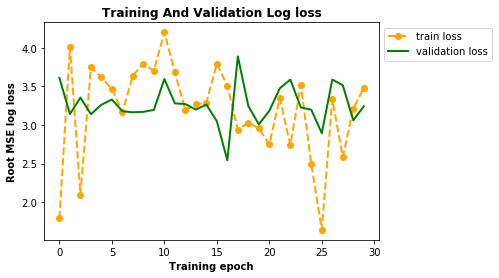

In [454]:
plt.plot(errorplot, 'o--', linewidth=2,color='orange', label ='train loss')
plt.plot(valerror, '-', linewidth=2,color='green',  label ='validation loss')

plt.title("Training And Validation Log loss",fontweight='bold')
plt.ylabel("Root MSE log loss",fontweight='bold')
plt.xlabel("Training epoch",fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1,0.9))


### Test Data


In [455]:
testpath= BASE_DIR + cfg['cleanedtest']['TargetDir']
#testDataName= cfg['cleanedtest']['testFeatureSet']
testName = cfg['cleanedtest']['LSTMtestFeatureSet']
testzero =  cfg['cleanedtest']['testDatasetName']
testpoints = 10000

In [456]:
#test = np.load(testpath + testName)


In [457]:
#test = test[:testpoints]

In [330]:
# do not run twice
true_readings = pd.read_csv(testpath + testzero,nrows=testpoints) 

In [308]:
#test = normalize(test,axis=0, norm='l1' )

In [458]:
results = []
shape = test.shape[1] - 1 # -1 to remove the target variable
start = 0
test_batch =30
end = test_batch
length = test.shape[0]//test_batch

for row in range(0,length+1): # plus one to 
        #print(row[1:].shape[0])
        #print(row)
        rows = normalize(test[start:end],axis=0, norm='l2')
        
        if row == test.shape[0]//test_batch and testpoints%test_batch !=0:
            last = testpoints%test_batch 
            rows = normalize(test[-last:],axis=0, norm='l2')
        elif row == test.shape[0]//test_batch :
            break
        
        for i in rows:
            
            i = i[1:]
            final_outputs = sess.run([ final_output],
                                             feed_dict = {
                                             input_layer: i.reshape(1,shape)})
            results.append(final_outputs)
        start +=test_batch
        end  += test_batch
    
len(results)

10000

In [459]:
predictions = np.array(results[:]).reshape(testpoints,)

In [460]:
# compare plots with that below

Text(0.5, 0, 'Iterations')

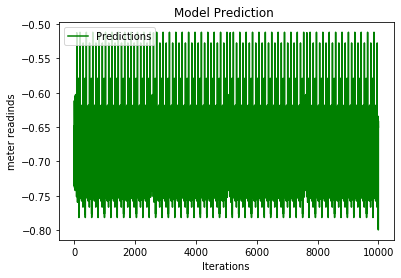

In [461]:
plt.plot(predictions,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

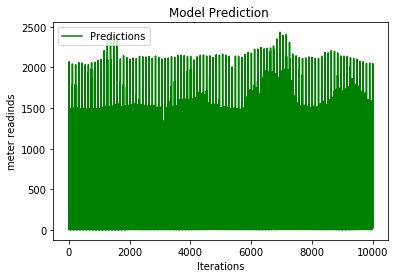

In [148]:
plt.plot(true_readings.meter_reading,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

In [397]:
# test predictions
test_predicted = pd.DataFrame(list(zip(list(true_readings.building_id),list(true_readings.timestamp),list(predictions))),columns= ['building_id','timestamp', 'meter_reading' ] )

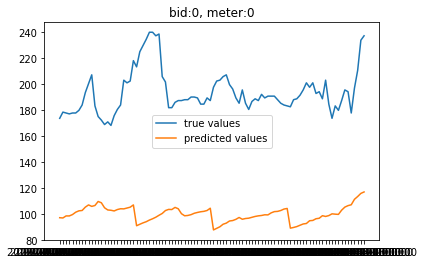

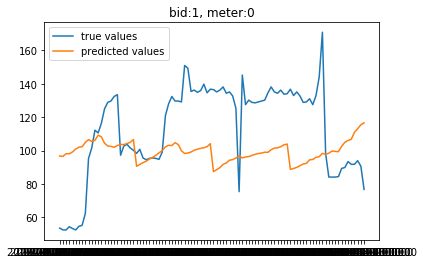

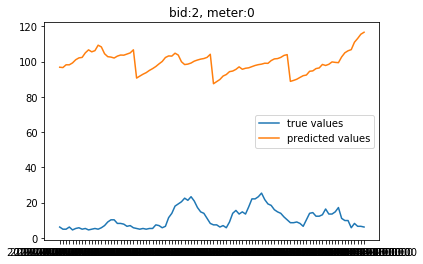

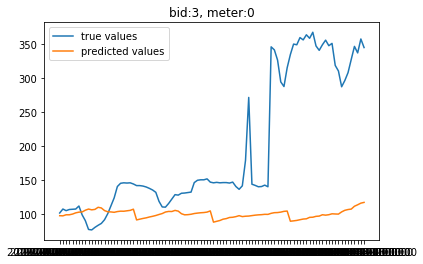

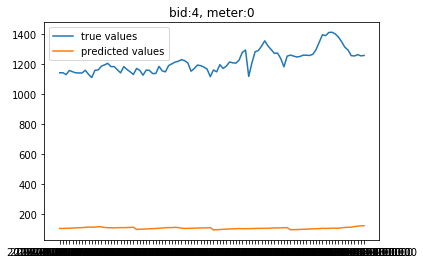

In [398]:
utils.plot_meter(true_readings,test_predicted,bn=5)

In [13]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# %matplotlib inline
# img  = mpimg.imread('true_plot.png')
# imgplot = plt.imshow(img)
# plt.show()

# Close Session

In [ ]:
sess.close()